In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Optional
from typing import Union
from typing import Tuple
from typing import List
import torch.nn as nn
import numpy as np
import torch
import math
import os

/xuan/envs/gj001/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir= '../data/mnist/train/mnist_train.csv'
test_dir= '../data/mnist/test/mnist_test.csv'

In [3]:
def read_mnist(file_name):
    mnist= []
    with open(file_name, encoding= 'utf-8') as f:
        mnist= f.readlines()
    rows= len(mnist)
    mnist= np.array([int(item) for sting in mnist for item in sting.split(',')]).reshape(rows, -1)
    return torch.from_numpy(mnist[:, 1:]).float()/ 255.0, torch.from_numpy(mnist[:, 0])

In [4]:
seed, batch_size= 1, 512
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
pics, labels= read_mnist(train_dir)
random_num= torch.rand(len(pics))
train_flag, valid_flag, test_flag= random_num< torch.tensor(0.8), (random_num>= torch.tensor(0.8))* (random_num< torch.tensor(0.9)), random_num>= torch.tensor(0.9)
train_pics, valid_pics, test_pics= pics[train_flag], pics[valid_flag], pics[test_flag]
train_labels, valid_labels, test_labels= labels[train_flag], labels[valid_flag], labels[test_flag]
train_set, valid_set, test_set= torch.utils.data.TensorDataset(train_pics, train_labels), torch.utils.data.TensorDataset(valid_pics, valid_labels), torch.utils.data.TensorDataset(test_pics, test_labels)
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)

In [5]:
class Tools:
    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c= consts.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)


In [6]:
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model= eps_model
        self.beta= torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha= 1.0- self.beta
        # compute cumulative product
        self.alpha_bar= torch.cumprod(self.alpha, dim= 0)
        self.n_steps= n_steps
        self.sigma= self.beta
        self.tools= Tools()

    # forward- diffusion
    def q_xt_x0(self, x0: torch.tensor, t:torch.Tensor):
        # compute mean and var of xt according to x0
        # xt= sqrt(at)*x0+ sqrt(1-at)*eps
        maen= self.tools.gather(self.alpha_bar, t)** 0.5* x0
        # (batch_size, 1, 1, 1)
        var= 1- self.tools.gather(self.alpha_bar, t)
        return maen, var

    # forward- diffusion
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]= None):
        # compute xt according mean and var of xt
        if eps is None:
            eps= torch.randn_like(x0)
        maen, var= self.q_xt_x0(x0, t)
        return maen+ (var** 0.5)* eps
    
    # sampling
    def p_sample(self, xt: torch.tensor, t: torch.Tensor):
        # compute xt-1 according xt
        eps_hat= self.eps_model(xt, t)
        alpha_bar= self.tools.gather(self.alpha_bar, t)
        alpha= self.tools.gather(self.alpha, t)
        eps_coef= (1- alpha)/ (1- alpha_bar)** 0.5
        maen= 1/ (alpha** 0.5)* (xt- eps_coef* eps_hat)
        var= self.tools.gather(self.sigma, t)
        eps= torch.randn(xt.shape, device= xt.device)
        return maen+ (var** 0.5)* eps
    
    # loss
    # x0, (batch_size, C, H, W);
    def loss(self, x0: torch.tensor, noise: Optional[torch.Tensor]= None):
        # distance between loss
        batch_size= x0.shape[0]
        # (batch_size, )
        t= torch.randint(0, self.n_steps, (batch_size, ), device= x0.device, dtype= torch.long)
        if noise is None:noise= torch.randn_like(x0)
        xt= self.q_sample(x0, t, eps= noise)
        eps_hat= self.eps_model(xt, t)
        return F.mse_loss(noise, eps_hat)


In [7]:
class Swish(nn.Module):
    def forward(self, x):
        return x* torch.sigmoid(x)

In [8]:
class ResidualBolck(nn.Module):
    # n_groups, hyper-parameter of group norm
    # group norm, group normalize; first, split channels into different groups; then, normalize feature in every group, as batch_normalization, it has some hyper-parameters.
    # feat_map  
    # cv1(feat_map)+ cv2(time_emb) -> feat_map' + cv(feat_map) -> output
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int= 16, dropout: float= 0.1):
        super().__init__()
        # in_channels// n_groups
        self.norm1= nn.GroupNorm(n_groups, in_channels)
        self.act1= Swish()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        self.norm2= nn.GroupNorm(n_groups, out_channels)
        self.act2= Swish()
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        if in_channels!= out_channels:
            self.shortcut= nn.Conv2d(in_channels, out_channels, kernel_size= (1, 1))
        else:
            self.shortcut= nn.Identity()
        self.time_emb= nn.Linear(time_channels, out_channels)
        self.time_act= Swish()
        self.dropout= nn.Dropout(dropout)
    def forward(self, x: torch.Tensor, t:torch.Tensor):
        # norm>> act>> conv
        h= self.conv1(self.act1(self.norm1(x)))
        # time embedding, (batch_size, out_channels, 1, 1)
        # time embedding的不同特征与不同通道的特征图进行相加以实现空间与时间的融合
        h+= self.time_emb(self.time_act(t))[:, :, None, None]
        h= self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h+ self.shortcut(x)


In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int= 1, k_dims: int= None, n_groups: int= 16):
        super().__init__()
        if k_dims is None:
            k_dims= n_channels
        self.norm= nn.GroupNorm(n_groups, n_channels)
        # as n_channels= 64, 64>> 8* 128* 3
        self.projection= nn.Linear(n_channels, n_heads* k_dims* 3)
        self.output= nn.Linear(n_heads* k_dims, n_channels)
        self.scale= k_dims** -0.5
        self.n_heads= n_heads
        self.k_dims= k_dims
    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor]= None):
        _= t
        batch_size, n_channels, height, weight= x.shape
        # pull x straight, (batch_size, n_channels, H* W)>> (batch_size, H* W, n_channels)
        x= x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # (batch_size, H* W, channels)>> (batch_size, H* W, head, 3* k_head_dim)
        qkv= self.projection(x).view(batch_size, -1, self.n_heads, 3* self.k_dims)
        # q, (batch_size, H* W, head, k_head_dim); k, (batch_size, H* W, head, k_head_dim); v, (,,).
        q, k, v= torch.chunk(qkv, 3, dim= -1)
        # (batch_size, H* W, head, dim), (batch_size, H* W, head, dim) -> (batch_size, H* W, H* W, head)
        # This writing style is really good!
        attn= torch.einsum('bihd,bjhd->bijh', q, k)* self.scale
        attn= attn.softmax(dim= 2)
        # (batch_size, H* W, H* W, head), (batch_size, H* W, head, dim)
        res= torch.einsum('bijh,bjhd->bihd', attn, v)
        # (batch_size, H* W, head* dim)
        res= res.view(batch_size, -1, self.n_heads* self.k_dims)
        # (batch_size, H* W, C)
        res= self.output(res)
        res+= x
        res= res.permute(0, 2, 1).view(batch_size, n_channels, height, weight)
        return res

In [10]:
class DownBlock(nn.Module):
    # Encoder
    # DownBlock= ResidualBlock+ AttentionBlock
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res= ResidualBolck(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x= self.res(x, t)
        x= self.attn(x)
        return x

In [11]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels:int):
        super().__init__()
        self.n_channels= n_channels
        # n_channels// 8 and concate
        self.lin1= nn.Linear(self.n_channels// 4, self.n_channels)
        self.act= Swish()
        self.lin2= nn.Linear(self.n_channels, self.n_channels)
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 8
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1)
        # transform
        emb= self.act(self.lin1(emb))
        emb= self.lin2(emb)
        return emb        

In [12]:
class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        # 反卷积，
        self.conv= nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _= t
        return self.conv(x)

In [13]:
class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv= nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))
    def forward(self, x:torch.tensor, t:torch.tensor):
        _= t
        return self.conv(x)

In [14]:
class MiddleBlock(nn.Module):
    def __init__(self, n_channels:int, time_channels:int):
        super().__init__()
        self.res1= ResidualBolck(n_channels, n_channels, time_channels)
        self.attn= AttentionBlock(n_channels)
        self.res2= ResidualBolck(n_channels, n_channels, time_channels)
    def forward(self, x:torch.tensor, t:torch.tensor):
        x= self.res1(x, t)
        x= self.attn(x)
        x= self.res2(x, t)
        return x

In [15]:
class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # we concatenate the output of the same resolution
        self.res= ResidualBolck(in_channels+ out_channels, out_channels, time_channels)
        if has_attn:
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        x= self.res(x, t)
        x= self.attn(x)
        return x

In [16]:
class UNet(nn.Module):
    def __init__(self, image_channels: int= 1, n_channels: int= 16, ch_mults: Union[tuple[int, ...], List[int]]= [1, 2, 2, 2], is_attn: Union[Tuple[bool, ...], List[int]]= (False, False, False, False), n_blocks: int= 1):
        super().__init__()
        # 
        n_resolutions= len(ch_mults)
        self.image_proj= nn.Conv2d(image_channels, n_channels, kernel_size= (3, 3), padding= (1, 1))
        self.time_emb= TimeEmbedding(n_channels* 4)
        # ---- Encoder ----
        down= []
        out_channels= in_channels= n_channels
        # for each layers
        for i in range(n_resolutions):
            # 16* (1, 2, 2, 2)
            out_channels= in_channels* ch_mults[i]
            for _ in range(n_blocks):
                # residual+ attn
                down.append(DownBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
                in_channels= out_channels
            # downsample in each layer
            if i< n_resolutions- 1:
                # channels no change, (H, W)>> (H/2, W/ 2)
                down.append(Downsample(in_channels))
        self.down= nn.ModuleList(down)
        # middle, residual+ attn+ residual
        self.middle= MiddleBlock(out_channels, n_channels* 4)
        # Decoder
        up= []
        in_channels= out_channels
        # for each layer
        for i in reversed(range(n_resolutions)):
            # 
            out_channels= in_channels
            for _ in range(n_blocks):
                # residual+ attn
                up.append(UpBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
            out_channels= in_channels// ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
            in_channels= out_channels
            if i> 0:
                up.append(Upsample(in_channels))
        self.up= nn.ModuleList(up)
        self.norm= nn.GroupNorm(8, n_channels)
        self.act= Swish()
        self.final= nn.Conv2d(in_channels, image_channels, kernel_size= (3, 3), padding= (1, 1))
        
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t= self.time_emb(t)
        x= self.image_proj(x)
        # Encoder
        h= [x]
        for m in self.down:
            x= m(x, t)
            h.append(x)
        # Middle
        x= self.middle(x, t)
        # Decoder
        for m in self.up:
            if isinstance(m, Upsample):
                x= m(x, t)
            else:
                s= h.pop()
                x= torch.cat((x, s), dim= 1)
                x= m(x, t)
        return self.final(self.act(self.norm(x)))

In [17]:
lr, device, save_dir= 0.001, 'cuda:0', './u_net.pt'
u_net= UNet(1, 16, [1, 2, 2], [False, False, False], n_blocks= 1).to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= lr)

In [18]:
best_score, score, epochs, early_stop_time, early_stop_threshold= 1e10, 0, 200, 0, 40
for epoch in range(epochs):
    loss_record= []
    for step, (pic, labels) in enumerate(train_loader):
        pic= pic.view(-1, 1, 28, 28).to(device)
        opt_dm.zero_grad()
        loss= dm.loss(pic)
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()
    print(f'training epoch: {epoch}, mean loss: {torch.tensor(loss_record).mean()}')
    loss_record= []
    with torch.no_grad():
        for step, (pic, labels) in enumerate(valid_loader):
            pic= pic.view(-1, 1, 28, 28).to(device)
            loss= dm.loss(pic)
            loss_record.append(loss.item()) 
    mean_loss= torch.tensor(loss_record).mean()
    # early stopping
    if mean_loss< best_score:
        early_stop_time= 0
        best_score= mean_loss
        torch.save(u_net, f'{save_dir}')
    else:
        early_stop_time= early_stop_time+ 1
    if early_stop_time> early_stop_threshold:
        break
    # output
    print(f'early_stop_time/early_stop_threshold: {early_stop_time}/{early_stop_threshold}, mean loss: {mean_loss}')

training epoch: 0, mean loss: 0.13945572078227997
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.059204574674367905
training epoch: 1, mean loss: 0.04931377246975899
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.042829569429159164
training epoch: 2, mean loss: 0.03745728358626366
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.03439958393573761
training epoch: 3, mean loss: 0.032295700162649155
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.02823820896446705
training epoch: 4, mean loss: 0.02838054671883583
early_stop_time/early_stop_threshold: 1/40, mean loss: 0.028716417029500008
training epoch: 5, mean loss: 0.025854943320155144
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.025475846603512764
training epoch: 6, mean loss: 0.02481590397655964
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.023209378123283386
training epoch: 7, mean loss: 0.023541387170553207
early_stop_time/early_stop_threshold: 0/40, mean loss: 0.0220172945

In [18]:
def show_sample(images, texts):
    _, figs= plt.subplots(1, len(images), figsize= (12, 12))
    for text, f, img in zip(texts, figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        f.text(0.5, 0, text, ha= 'center', va= 'bottom', fontsize= 12, color= 'white', backgroundcolor= 'black')
    plt.show()

In [20]:
xt, images, texts= torch.randn((1, 1, 28, 28), device= device), [], []
u_net= torch.load(f'{save_dir}')
dm= DenoiseDiffusion(u_net, 1000, device= device)
for t in reversed(range(1000)):
    xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
    xt= xt_1
    if (t+ 1)% 100== 1:
        images.append(xt.view(1, 28, 28).to('cpu').detach())
        texts.append(t+ 1)

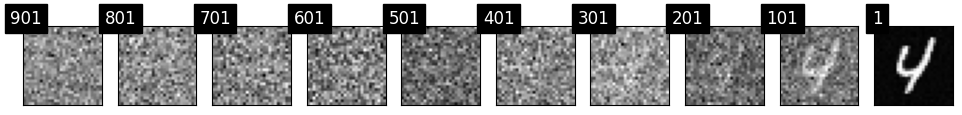

In [21]:
images_= torch.stack(images, dim= 0)
show_sample(images_, texts)